In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

print(torch.cuda.is_available())

True


In [2]:
from torch.utils.tensorboard import SummaryWriter

2024-06-19 23:49:13.339940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 23:49:15.259980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading the CelebA dataset

Stanford Dataset retrieved from kaggle.com/datasets/jessicali9530/celeba-dataset

In [3]:
# !pip install kaggle
# kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

In [4]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [5]:

class CelebADataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load the data
        self.attrs = pd.read_csv(os.path.join(root_dir, 'list_attr_celeba.csv'))
        self.bbox = pd.read_csv(os.path.join(root_dir, 'list_bbox_celeba.csv'))
        self.landmarks = pd.read_csv(os.path.join(root_dir, 'list_landmarks_align_celeba.csv'))
        self.partitions = pd.read_csv(os.path.join(root_dir, 'list_eval_partition.csv'))

        # Filter by split
        if split == 'train':
            self.data = self.partitions[self.partitions['partition'] == 0]
        elif split == 'valid':
            self.data = self.partitions[self.partitions['partition'] == 1]
        elif split == 'test':
            self.data = self.partitions[self.partitions['partition'] == 2]
        else:
            raise ValueError("Split must be 'train', 'valid', or 'test'")

        # Merge the attributes with the filtered partition data
        self.data = self.data.merge(self.attrs, on='image_id')
        self.data = self.data.merge(self.bbox, on='image_id')
        self.data = self.data.merge(self.landmarks, on='image_id')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 'img_align_celeba', 'img_align_celeba', self.data.iloc[idx, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        # Convert attributes to tensor
        attributes = self.data.iloc[idx, 1:].values.astype('int')
        attributes = torch.tensor(attributes, dtype=torch.float32)

        return image, attributes

# Define the transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizing around 0 with a range of [-1, 1]
    ]),
    'test': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizing around 0 with a range of [-1, 1]
    ]),
}

# Create the datasets
train_dataset = CelebADataset(root_dir='/home/user/krishnanm0/dataset', split='train', transform=data_transforms['train'])
test_dataset = CelebADataset(root_dir='/home/user/krishnanm0/dataset', split='test', transform=data_transforms['test'])
BATCH_SIZE = 32
# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Visualizing some Images

In [7]:
from PIL import Image

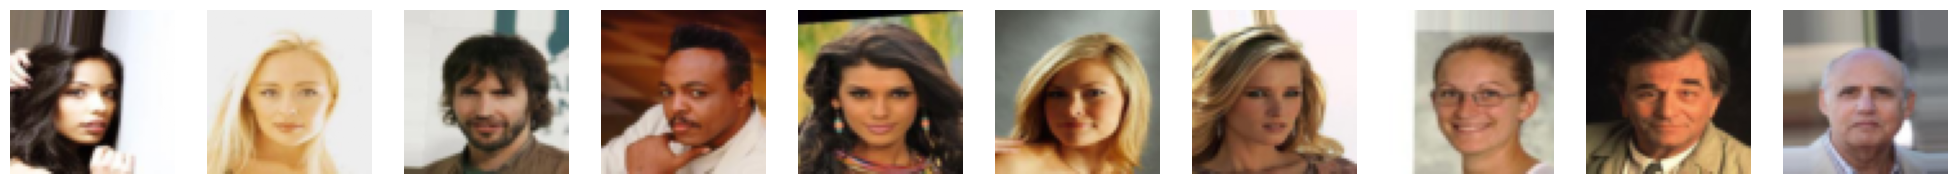

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image (reverse the normalization)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select 10 random images
indices = np.random.choice(range(images.size(0)), size=10, replace=False)
random_images = images[indices]

# Display the images
fig, axes = plt.subplots(1, 10, figsize=(25, 4))
for idx, img in enumerate(random_images):
    ax = axes[idx]
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

plt.show()

## Main Code

#### Template

In [16]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [17]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        kld_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            if writer is not None:
                grid = torchvision.utils.make_grid(images[:64].cpu())
                writer.add_image('images', grid, epoch)
                grid = torchvision.utils.make_grid(recons[:64].cpu())
                writer.add_image('output_images', grid, epoch)
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, savepath, writer, save_frequency=5):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)

        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch)
        writer.add_scalars(f'Loss/All_Valid_Loss', {"recons": recons_loss.item(), "kld": kld_loss.item()}, global_step=epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch)
        writer.add_scalars(f'Loss/Comb', {"train": mean_loss.item(), "valid": loss.item()}, global_step=epoch)
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = CONFIG["random_seed"]
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return



def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


In [18]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()

### Model - Convolutional Variational Auto-encoder

In [44]:
class ConvVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=20, conv_channels=[32, 64, 128, 256], fc_channels=[1024, 512]):
        super(ConvVAE, self).__init__()
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels, conv_channels[0], kernel_size=4, stride=2, padding=1),  # 3x64x64 -> 32x32x32
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(conv_channels[0], conv_channels[1], kernel_size=4, stride=2, padding=1),  # 32x32x32 -> 64x16x16
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(conv_channels[1], conv_channels[2], kernel_size=4, stride=2, padding=1),  # 64x16x16 -> 128x8x8
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(conv_channels[2], conv_channels[3], kernel_size=4, stride=2, padding=1),  # 128x8x8 -> 256x4x4
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Flatten()  # 256x4x4 -> 4096
        )
        
        self.fc_mu = nn.Linear(conv_channels[3] * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(conv_channels[3] * 4 * 4, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, conv_channels[3] * 4 * 4)
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(conv_channels[3], conv_channels[2], kernel_size=4, stride=2, padding=1),  # 256x4x4 -> 128x8x8
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(conv_channels[2], conv_channels[1], kernel_size=4, stride=2, padding=1),  # 128x8x8 -> 64x16x16
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(conv_channels[1], conv_channels[0], kernel_size=4, stride=2, padding=1),  # 64x16x16 -> 32x32x32
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(conv_channels[0], in_channels, kernel_size=4, stride=2, padding=1),  # 32x32x32 -> 3x64x64
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def encode(self, x):
        x_enc = self.encoder_conv(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_log_var(x_enc)
        return mu, log_var
    
    def decode(self, z):
        x_hat_flat = self.decoder_fc(z)
        x_hat_flat = x_hat_flat.view(-1, 256, 4, 4)  # Reshape to match ConvTranspose2d input
        x_hat = self.decoder_conv(x_hat_flat)
        return x_hat
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, (z, mu, log_var)




## Training

### lambda_kld=1e-3

In [53]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [54]:
vae = ConvVAE()
vae = vae.to(device)

In [55]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "convVAE_k_1e3")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [56]:
savepath = "imgs/vae"
if not os.path.exists(savepath):
    os.makedirs(savepath)
model1 = vae

In [57]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1,)

In [ ]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model1, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer
    )

In [59]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

/tmp/ipykernel_4124484/892720532.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


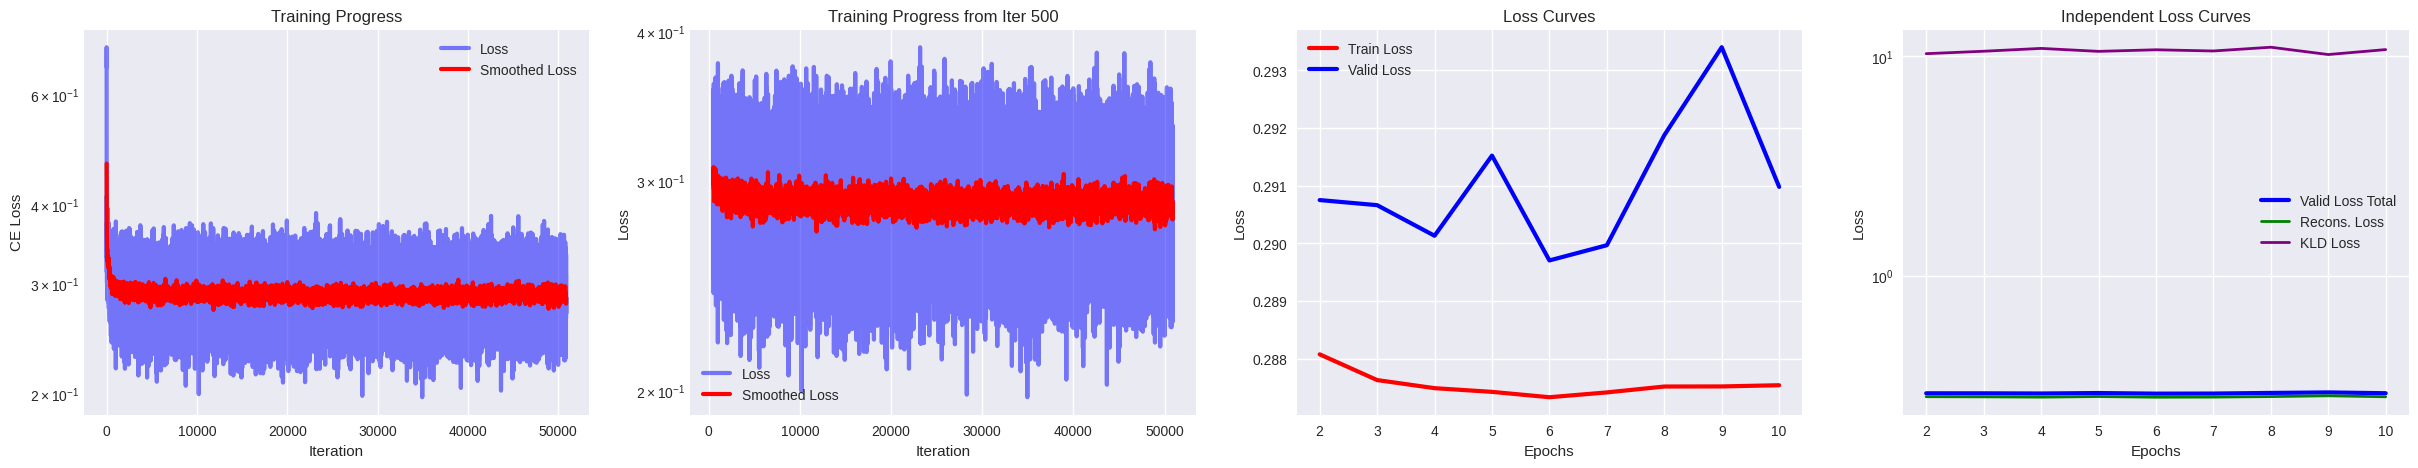

In [60]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4)
fig.set_size_inches(30,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3)
ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
ax[3].legend(loc="best")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Independent Loss Curves")

plt.show()

### lambda_kld=1e-1

In [28]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [29]:
vae = ConvVAE()
vae = vae.to(device)

TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "convVAE_k_1e1")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [30]:
savepath = "imgs/vae"
if not os.path.exists(savepath):
    os.makedirs(savepath)
model2 = vae

In [31]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1,)

In [32]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model1, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer
    )

Epoch 1 Iter 5087: loss 1.57129. : 100%|████████████████████████████████████████████| 5087/5087 [01:19<00:00, 64.12it/s]


    Train loss: 1.64774
    Valid loss: 1.63446
       Valid loss recons: 0.27156
       Valid loss KL-D:   13.62902


Epoch 6 Iter 5087: loss 1.64966. : 100%|████████████████████████████████████████████| 5087/5087 [01:18<00:00, 64.73it/s]


    Train loss: 1.64774
    Valid loss: 1.63446
       Valid loss recons: 0.27155
       Valid loss KL-D:   13.62902


Epoch 10 Iter 5087: loss 1.62059. : 100%|███████████████████████████████████████████| 5087/5087 [00:51<00:00, 98.85it/s]

    Train loss: 1.64772
    Valid loss: 1.63446
       Valid loss recons: 0.27156
       Valid loss KL-D:   13.62902
Training completed


In [33]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

/tmp/ipykernel_4124484/892720532.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


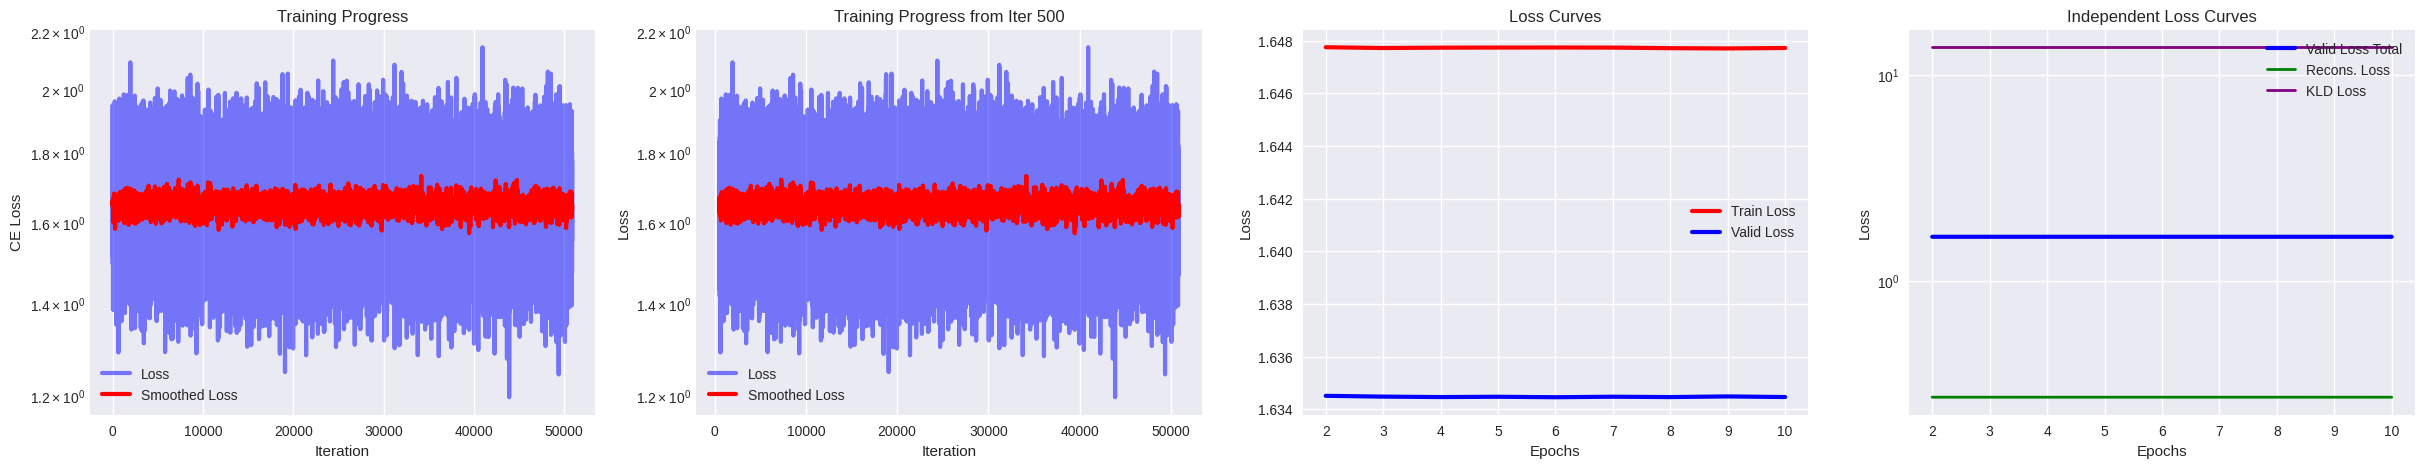

In [34]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4)
fig.set_size_inches(30,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3)
ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
ax[3].legend(loc="best")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Independent Loss Curves")

plt.show()

### lambda_kld=1e-2

In [36]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-2):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [37]:
vae = ConvVAE()
vae = vae.to(device)

TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "convVAE_k_1e2")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [38]:
savepath = "imgs/vae"
if not os.path.exists(savepath):
    os.makedirs(savepath)
model2 = vae

In [39]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1,)

In [40]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model1, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer
    )

Epoch 1 Iter 5087: loss 0.39563. : 100%|████████████████████████████████████████████| 5087/5087 [00:51<00:00, 98.08it/s]


    Train loss: 0.40283
    Valid loss: 0.40785
       Valid loss recons: 0.27156
       Valid loss KL-D:   13.62902


Epoch 6 Iter 5087: loss 0.40070. : 100%|███████████████████████████████████████████| 5087/5087 [00:49<00:00, 102.96it/s]


    Train loss: 0.40283
    Valid loss: 0.40784
       Valid loss recons: 0.27155
       Valid loss KL-D:   13.62902


Epoch 10 Iter 5087: loss 0.42694. : 100%|███████████████████████████████████████████| 5087/5087 [00:54<00:00, 92.78it/s]

    Train loss: 0.40285
    Valid loss: 0.40785
       Valid loss recons: 0.27156
       Valid loss KL-D:   13.62902
Training completed


In [41]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

/tmp/ipykernel_4124484/892720532.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


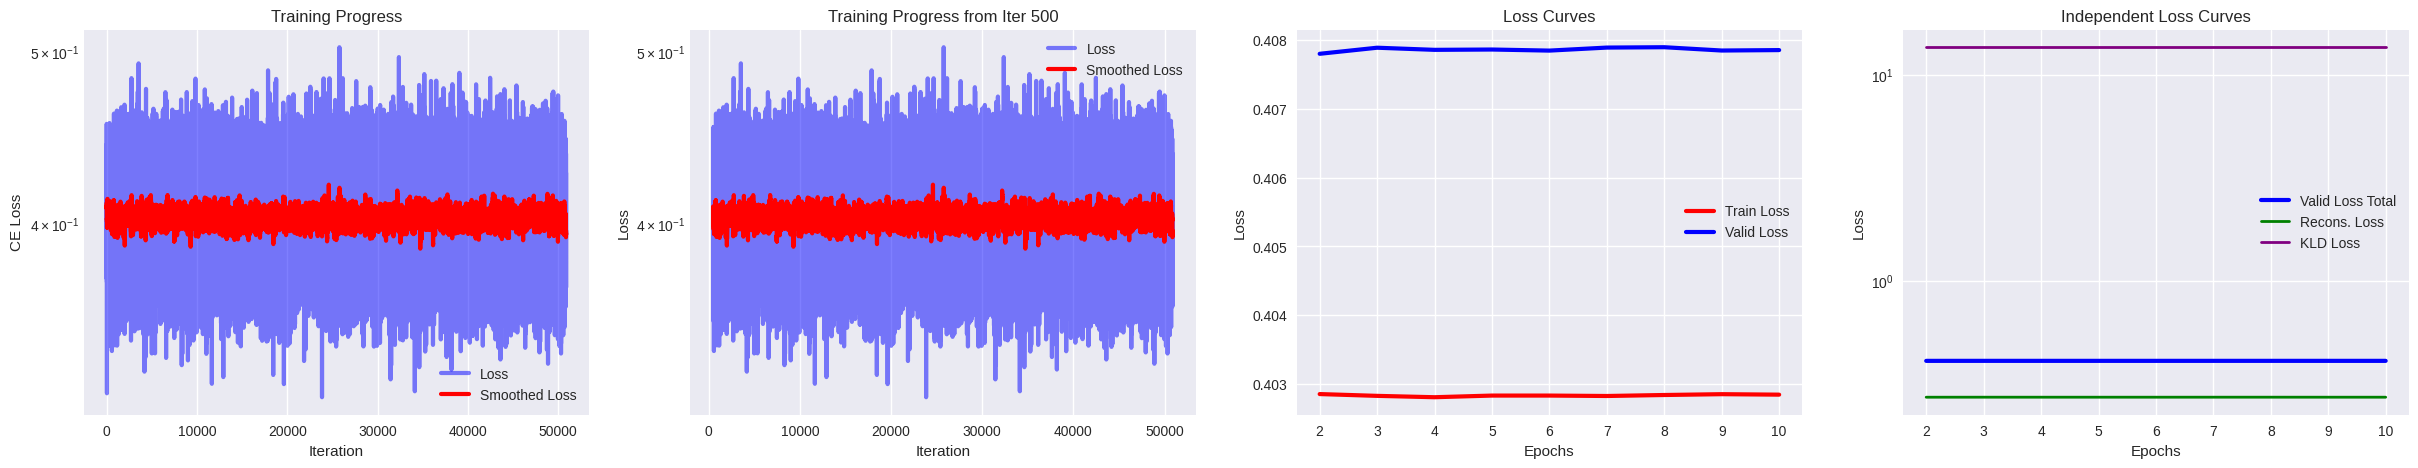

In [42]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4)
fig.set_size_inches(30,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3)
ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
ax[3].legend(loc="best")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Independent Loss Curves")

plt.show()

### lambda_kld=3e-2

In [46]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=5e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [47]:
vae = ConvVAE()
vae = vae.to(device)

TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "convVAE_k_5e3")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [48]:
savepath = "imgs/vae"
if not os.path.exists(savepath):
    os.makedirs(savepath)
model2 = vae

In [49]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1,)

In [50]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model1, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer
    )

Epoch 1 Iter 5087: loss 0.37651. : 100%|███████████████████████████████████████████| 5087/5087 [00:49<00:00, 103.06it/s]


    Train loss: 0.33368
    Valid loss: 0.33968
       Valid loss recons: 0.27154
       Valid loss KL-D:   13.62902


Epoch 6 Iter 5087: loss 0.31759. : 100%|███████████████████████████████████████████| 5087/5087 [00:49<00:00, 103.37it/s]


    Train loss: 0.33368
    Valid loss: 0.33975
       Valid loss recons: 0.2716
       Valid loss KL-D:   13.62902


Epoch 10 Iter 5087: loss 0.32801. : 100%|██████████████████████████████████████████| 5087/5087 [00:49<00:00, 102.71it/s]

    Train loss: 0.33367
    Valid loss: 0.33965
       Valid loss recons: 0.27151
       Valid loss KL-D:   13.62902
Training completed


In [51]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

/tmp/ipykernel_4124484/892720532.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


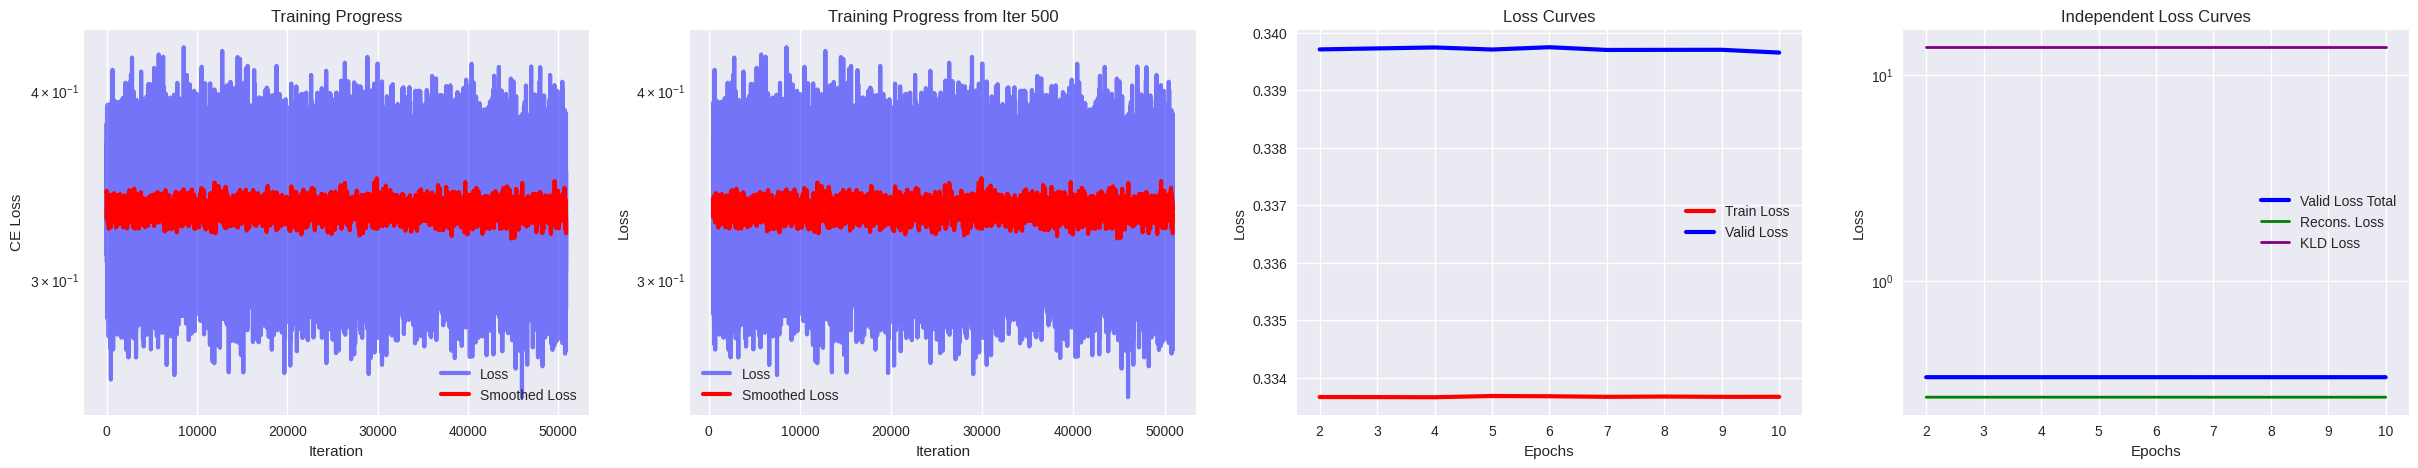

In [52]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4)
fig.set_size_inches(30,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[3].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss Total", linewidth=3)
ax[3].plot(epochs[1:], val_loss_recons[1:], c="green", label="Recons. Loss", linewidth=2)
ax[3].plot(epochs[1:], val_loss_kld[1:], c="purple", label="KLD Loss", linewidth=2)
ax[3].legend(loc="best")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Independent Loss Curves")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


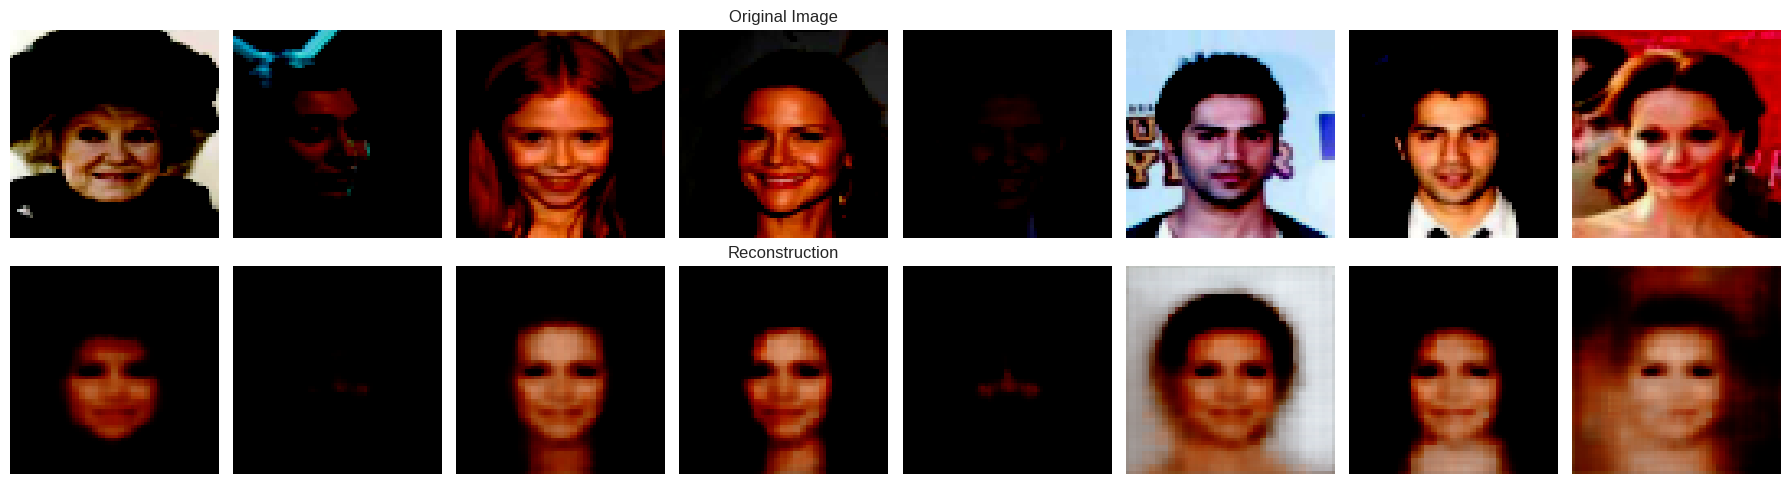

In [61]:
imgs, _ = next(iter(test_loader))


vae.eval()
with torch.no_grad():
    recons, _ = model1(imgs.to(device))

fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    # Original image
    ax[0, i].imshow(imgs[i].permute(1, 2, 0).cpu())  
    ax[0, i].axis("off")
    
    # Reconstruction
    ax[1, i].imshow(recons[i].permute(1, 2, 0).cpu())  
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

## Inference 

Generating new faces from latent codes

In [62]:
if not os.path.exists("imgs/inferecence_conv_vae"):
    os.makedirs("imgs/inferecence_conv_vae")

In [63]:
vae.eval()
with torch.no_grad():
    for i in range(5):
        z = torch.randn(32, 20).to(device) 
        sample = vae.decode(z)  
        save_image(sample.view(32, 3, 64, 64), f"imgs/inferecence_conv_vae/inference_{i}.png")

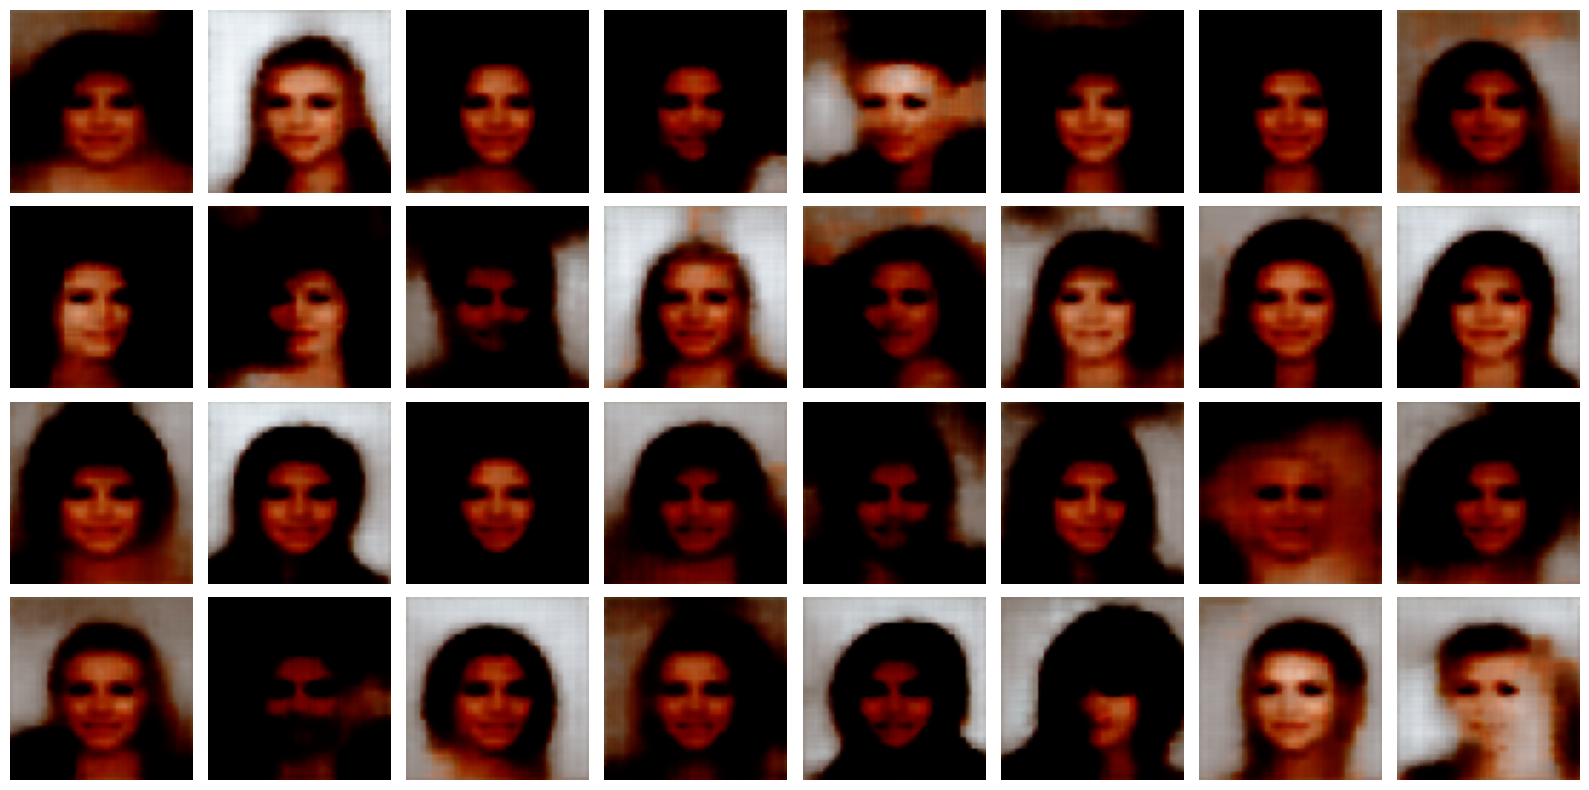

In [64]:
recons = sample.view(32, 3, 64, 64)
plt.figure(figsize=(8*2, 4*2))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(recons[i].cpu().permute(1, 2, 0))  
    plt.axis("off")

plt.tight_layout()
plt.show()

## Analysis

## Interpolation

In [94]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-3, 3), N=12):
    """
    Sampling equispaced points from the latent space given the xrange and yrange,
    decoding latents and visualizing the distribution of the space.
    """
    SIZE = 64  # Assuming your images are 64x64
    LATENT_DIM = 20  # Assuming the latent space dimension is 20
    grid = np.empty((N * SIZE, N * SIZE, 3))  # Initialize grid for RGB images

    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.zeros(1, LATENT_DIM).to(device)
            z[0, 0] = x
            z[0, 1] = y
            x_hat = model.decode(z).cpu()
            x_hat = x_hat - x_hat.min()
            x_hat = x_hat / x_hat.max()
            x_hat = x_hat.view(3, SIZE, SIZE).permute(1, 2, 0)  # Reshape to (height, width, channels)
          
            grid[i * SIZE:(i + 1) * SIZE, j * SIZE:(j + 1) * SIZE] = x_hat.numpy()

    plt.figure(figsize=(12, 12))
    plt.imshow(grid, extent=[xrange[0], xrange[1], yrange[0], yrange[1]])
    plt.axis("off")
    plt.show()




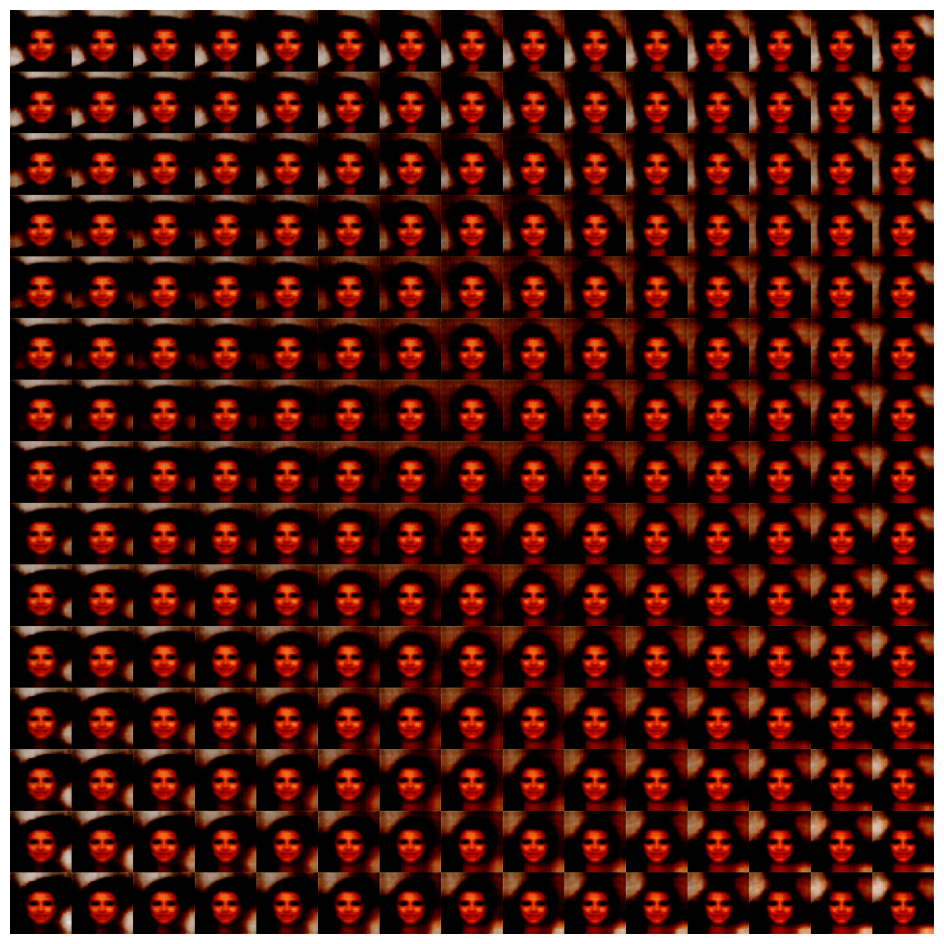

In [95]:
plot_reconstructed(model1, xrange=(-3, 3), yrange=(-3, 3), N=15)

In [98]:
# img1 = test_dataset[0][0]
img1 = test_dataset[100][0]
img2 = test_dataset[16][0]
img1 = img1 - img1.min()
img1 = img1 / img1.max()

img2 = img2 - img2.min()
img2 = img2 / img2.max()


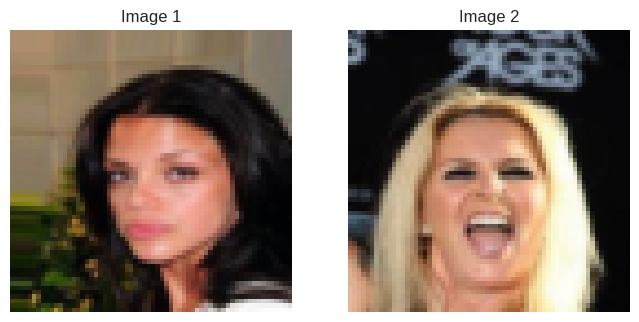

In [99]:
plt.subplot(1,2,1)
plt.imshow(img1.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Image 2")
plt.show()

In [102]:

img1, img2 = img1.to(device), img2.to(device)

with torch.no_grad():
    encoded = model1.encode(torch.stack([img1, img2]))
    mu, log_var = encoded

std = torch.exp(0.5 * log_var)
latents = mu + std * torch.randn_like(std)
latent1, latent2 = latents[0], latents[1]

In [107]:
import torch

@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """
    
    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decode(z)
    decoded_imgs = decoded.cpu().view(-1, 64, 64, 3).permute(0, 3, 1, 2)  # Reshape to (N, 3, 64, 64)
    return decoded_imgs


In [108]:
decoded_imgs = sample_interpolation(model1, latent2, latent1, N=12)

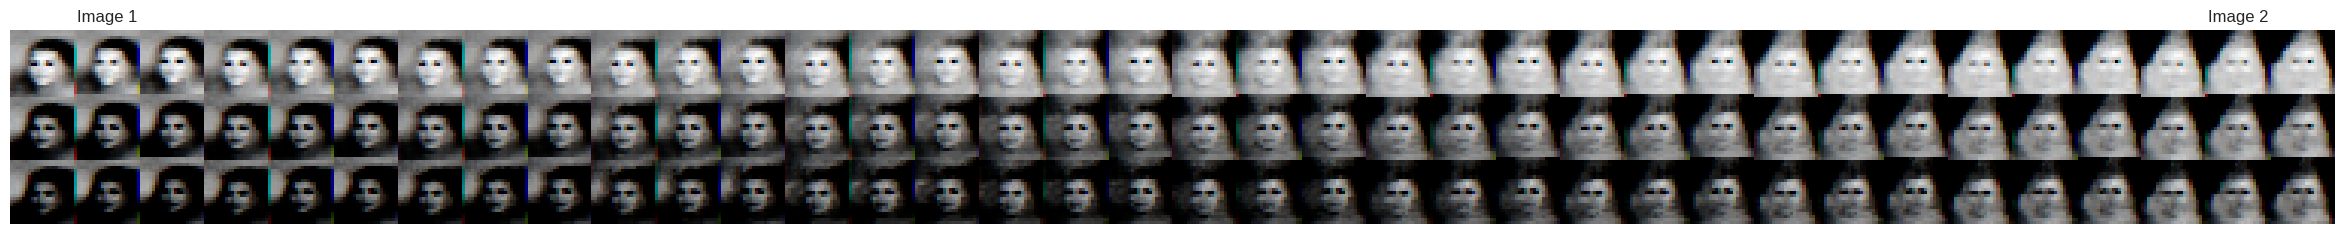

In [111]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30, 3))
for i, img in enumerate(decoded_imgs):
    img = img - img.min()
    img = img / img.max()
    ax[i].imshow(img.permute(1, 2, 0))  
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0, hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()